In [1]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 3.8 MB/s eta 0:00:00


Epoch [10/200] Train Loss: 0.3378 Val Loss: 0.0718
Epoch [20/200] Train Loss: 0.0692 Val Loss: 0.0557
Epoch [30/200] Train Loss: 0.0531 Val Loss: 0.0378
Epoch [40/200] Train Loss: 0.0448 Val Loss: 0.0361
Epoch [50/200] Train Loss: 0.0426 Val Loss: 0.0349
Epoch [60/200] Train Loss: 0.0386 Val Loss: 0.0332
Epoch [70/200] Train Loss: 0.0374 Val Loss: 0.0321
Epoch [80/200] Train Loss: 0.0362 Val Loss: 0.0320
Epoch [90/200] Train Loss: 0.0354 Val Loss: 0.0309
Epoch [100/200] Train Loss: 0.0357 Val Loss: 0.0317
Epoch [110/200] Train Loss: 0.0351 Val Loss: 0.0309
Epoch [120/200] Train Loss: 0.0339 Val Loss: 0.0316
Epoch [130/200] Train Loss: 0.0337 Val Loss: 0.0310
Epoch [140/200] Train Loss: 0.0337 Val Loss: 0.0310
Epoch [150/200] Train Loss: 0.0337 Val Loss: 0.0312
Epoch [160/200] Train Loss: 0.0332 Val Loss: 0.0314
Epoch [170/200] Train Loss: 0.0339 Val Loss: 0.0314
Epoch [180/200] Train Loss: 0.0335 Val Loss: 0.0312
Epoch [190/200] Train Loss: 0.0329 Val Loss: 0.0319
Epoch [200/200] Train

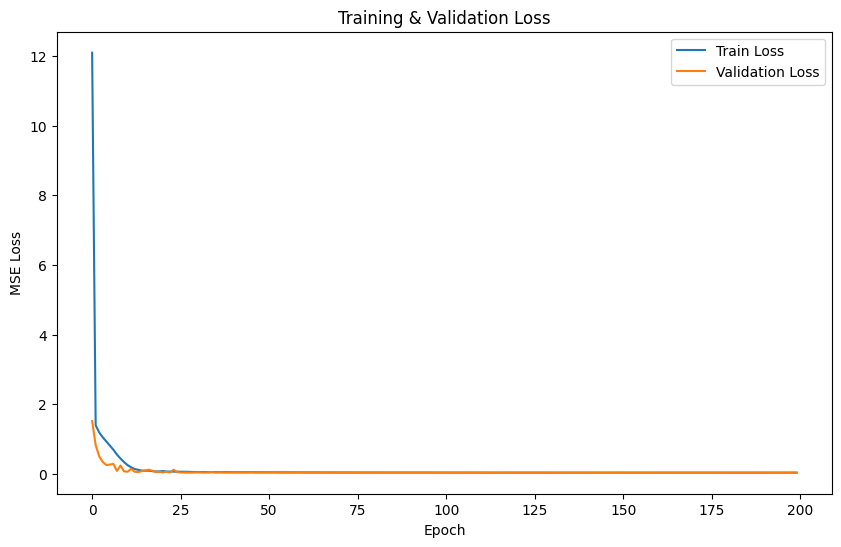

In [4]:
# ==========================
# Import Libraries
# ==========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from category_encoders import TargetEncoder

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# ==========================
# Load Dataset
# ==========================
data = pd.read_csv('kc_house_data.csv')

# ==========================
# Drop Unnecessary Columns
# ==========================
drop_cols = ['date', 'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15']
data = data.drop(columns=drop_cols)

# ==========================
# Feature Engineering
# ==========================
data['basement_exists'] = data['sqft_basement'].apply(lambda x: 1 if x > 0 else 0)
median_nonzero = data.loc[data['sqft_basement'] > 0, 'sqft_basement'].median()
data['sqft_basement_imputed'] = data['sqft_basement'].replace(0, median_nonzero)

ordinal_cols = ['condition', 'grade']
le = LabelEncoder()
for col in ordinal_cols:
    data[col] = le.fit_transform(data[col])

# ==========================
# Log-transform Target
# ==========================
data['price_log'] = np.log1p(data['price'])

numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols.remove('price')
numeric_cols.remove('price_log')

X = data[numeric_cols]
y = data['price_log']

# ==========================
# Train-Validation-Test Split
# ==========================
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42)

# ==========================
# Target Encoding for 'zipcode'
# ==========================
encoder = TargetEncoder(cols=['zipcode'])
encoder.fit(X_train['zipcode'], y_train)

X_train['zipcode'] = encoder.transform(X_train['zipcode'])
X_val['zipcode'] = encoder.transform(X_val['zipcode'])
X_test['zipcode'] = encoder.transform(X_test['zipcode'])

# ==========================
# Feature Scaling
# ==========================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1,1)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1,1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1,1)

# ==========================
# DataLoaders
# ==========================
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=32)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32)

# ==========================
# ANN Model with BatchNorm + Dropout
# ==========================
class ImprovedANN(nn.Module):
    def __init__(self, input_dim):
        super(ImprovedANN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64,1)
        )
    def forward(self, x):
        return self.model(x)

input_dim = X_train_scaled.shape[1]
model = ImprovedANN(input_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10)

# ==========================
# Train Model
# ==========================
num_epochs = 200
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
    epoch_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    scheduler.step(epoch_val_loss)  # reduce lr if val_loss plateaus

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {epoch_train_loss:.4f} Val Loss: {epoch_val_loss:.4f}")

# ==========================
# Evaluate Model
# ==========================
model.eval()
with torch.no_grad():
    y_train_pred = np.expm1(model(X_train_tensor).numpy())
    y_val_pred = np.expm1(model(X_val_tensor).numpy())
    y_test_pred = np.expm1(model(X_test_tensor).numpy())

from sklearn.metrics import mean_squared_error, r2_score

print("Training MSE:", mean_squared_error(np.expm1(y_train), y_train_pred))
print("Validation MSE:", mean_squared_error(np.expm1(y_val), y_val_pred))
print("Test MSE:", mean_squared_error(np.expm1(y_test), y_test_pred))
print("Training R2:", r2_score(np.expm1(y_train), y_train_pred))
print("Validation R2:", r2_score(np.expm1(y_val), y_val_pred))
print("Test R2:", r2_score(np.expm1(y_test), y_test_pred))

# ==========================
# Plot Loss Curves
# ==========================
plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()
